# Setup

In [1]:
!pip install --upgrade --force-reinstall --no-deps --quiet kaggle

     |████████████████████████████████| 58 kB 5.5 MB/s 


In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c tensorflow-great-barrier-reef -p /content/starfish

100% 14.2G/14.2G [03:04<00:00, 102MB/s] 
100% 14.2G/14.2G [03:04<00:00, 82.7MB/s]


In [10]:
!unzip -q /content/starfish/*.zip -d /content/starfish/

In [11]:
!rm /content/starfish/*.zip

# Dataset

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json

In [3]:
!ls /content/starfish

example_sample_submission.csv  greatbarrierreef  train.csv
example_test.npy	       test.csv		 train_images


In [4]:
train_df = pd.read_csv('/content/starfish/train.csv')

In [5]:
#img_sizes = []
#c = 0
#for fpath in image_filepaths:
#    img_size = keras.preprocessing.image.load_img(fpath).size
#    img_sizes.append(img_size)
#    c += 1
#    if c % 1000 == 0:
#        print(f"{c}/{len(image_filepaths)}")

# ALL IMAGES (1280, 720) - (W, H)

In [6]:
# 
# Get image dataset
#
# Note: Class = video_id
train_images_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/content/starfish/train_images/',
    validation_split=None,
    seed=123,
    image_size=(256,256),
    batch_size=1,
    label_mode=None
)
image_filepaths = train_images_ds.file_paths
train_images_ds = train_images_ds.map(lambda x: x / 255.0)

Found 23501 files belonging to 1 classes.


In [7]:
#
# Get filename dataset
#
# Note: filepath = /content/starfish/train_images/{video_id}/{video_frame}.jpg
train_fnames_ds = tf.data.Dataset.from_tensor_slices(image_filepaths)

In [8]:
#
# Get annotation dataset
#
# Note: image_id = {video_id}-{video_frame}
fpaths = image_filepaths
fpaths = [fpath.split('/content/starfish/train_images/')[1] for fpath in fpaths]
image_id = [fpath.split('/')[0][-1] + '-' + fpath.split('/')[1].split('.')[0] for fpath in fpaths]
abs_annotations_df = train_df[['image_id', 'annotations']].set_index('image_id')
abs_annotations_df = abs_annotations_df.loc[image_id]
abs_annotations_df = abs_annotations_df['annotations'].apply(lambda x: json.loads(x.replace("'", '"')))
from collections import defaultdict
def process(x):
    # Format - (xmin, ymin, width, height)
    if len(x) == 0:
        out = []
    if len(x) == 1:
        out = x[0]
        out = [list(out.values())]
    if len(x) > 1:
        out = []
        for d in x:
            out.append(list(d.values()))
    return out
def convert_abs_to_rel(abs_annotations, img_size=(1280, 720)):
    # img_size : (W, H)
    if len(abs_annotations) == 0:
        return abs_annotations
    else:
        W, H = img_size
        abs_annotations = np.array(abs_annotations) # :: (# of starfish, 4)
        scaling_factors = np.array([W, H, W, H])-1  # :: (4,)
        rel_annotations = abs_annotations / scaling_factors
        rel_annotations = rel_annotations.astype(np.float32)
        return rel_annotations

abs_annotations_df = abs_annotations_df.apply(process)
rel_annotations_df = abs_annotations_df.apply(convert_abs_to_rel)
annotation_flags = ~rel_annotations_df.apply(lambda x: len(x) == 0)
annotations_ragged = tf.ragged.constant(rel_annotations_df)
train_annotations_ds = tf.data.Dataset.from_tensor_slices(annotations_ragged)
train_annotation_flags_ds = tf.data.Dataset.from_tensor_slices(annotation_flags)

In [10]:
#
# Get target bounds delta: 
#   - always from left to right
#   - ie. 100% = @ right edge, 0% = @ left edge
#   - Note: images provided in training set are (1280, 720)
#
def get_rightside_tar_bounds(annotations):
    if len(annotations) == 0:
        return annotations
    else:
        annotations = np.array(annotations)
        rside_tar_bounds = annotations[:, 0] + annotations[:, 2]
        return rside_tar_bounds

rside_tar_bounds = rel_annotations_df.apply(get_rightside_tar_bounds)
rside_tar_bounds_ragged = tf.ragged.constant(rside_tar_bounds)
rside_tar_bounds_ds = tf.data.Dataset.from_tensor_slices(rside_tar_bounds_ragged)

In [11]:
#
# Combine datasets
#
train_ds = tf.data.Dataset.zip((train_fnames_ds, train_images_ds, train_annotations_ds, train_annotation_flags_ds, rside_tar_bounds_ds))
train_ds = train_ds.map(lambda v,w,x,y,z: {'filename': v, 'image': w, 'annotations': x.to_tensor(), 'has_annotation': y, 'rside_tar_bounds': z})

In [12]:
next(iter(train_ds))

{'annotations': <tf.Tensor: shape=(0, 0), dtype=float32, numpy=array([], shape=(0, 0), dtype=float32)>,
 'filename': <tf.Tensor: shape=(), dtype=string, numpy=b'/content/starfish/train_images/video_2/9675.jpg'>,
 'has_annotation': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'image': <tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
 array([[[[0.02034314, 0.36360294, 0.5133578 ],
          [0.01997549, 0.36789215, 0.49375   ],
          [0.03210784, 0.3408088 , 0.46348038],
          ...,
          [0.03884804, 0.2192402 , 0.32120097],
          [0.03137255, 0.23529412, 0.32941177],
          [0.04742647, 0.23137255, 0.33333334]],
 
         [[0.00281863, 0.42205882, 0.5726716 ],
          [0.00110294, 0.40061274, 0.5204657 ],
          [0.05269608, 0.34681374, 0.46838236],
          ...,
          [0.03419118, 0.2185049 , 0.32046568],
          [0.03529412, 0.23137255, 0.32941177],
          [0.03137255, 0.23529412, 0.32941177]],
 
         [[0.04963235, 0.54240197, 0.5942

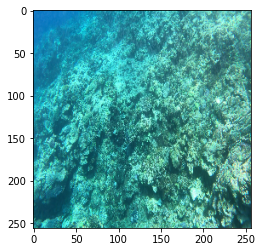

In [13]:
import matplotlib.pyplot as plt

sample = next(iter(train_ds))
plt.imshow(sample['image'][0])

### Object Flagging Dataset
- The constant shape image (256, 256)
- A gradient masking of the starfish using the annotations

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [15]:
# Assuming annotations are absolute
def from_annotations_to_gradient_mask(annotations, sigma, img_size=(720,1280), num_smooths=[0]):
    if len(annotations) == 0:
        return annotations
    # annotation - (xmin, ymin, width, height)
    mask = np.zeros(img_size, dtype=np.float32)
    for annotation in annotations:
        xmin, ymin, width, height = annotation
        mask[ymin:ymin+height, xmin:xmin+width] = 1.0

    grad_masks = []
    for i in range(num_smooths[0], num_smooths[-1]+1):
        if i in num_smooths:
            grad_masks.append(mask / mask.max())
        mask = gaussian_filter(mask, sigma=sigma)
    return grad_masks

In [16]:
abs_annotations_df

image_id
2-9675                                                    []
0-2121                                                    []
1-2194                                                    []
1-4453               [[644, 318, 32, 42], [325, 80, 44, 34]]
2-4243                                                    []
                                 ...                        
2-10390                                                   []
2-829                                                     []
2-305                                                     []
2-10703                                                   []
2-5772     [[623, 410, 55, 52], [637, 541, 55, 46], [734,...
Name: annotations, Length: 23501, dtype: object

In [17]:
smooth_cnts = [0, 4, 8, 16, 32, 64]
t_annotations = abs_annotations_df['2-5772']
t_img = cv2.imread("/content/starfish/train_images/video_2/5772.jpg") / 255.
t_grad_masks = from_annotations_to_gradient_mask(t_annotations, sigma=25.0, num_smooths=smooth_cnts)

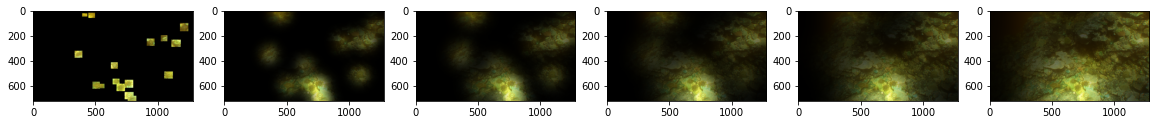

In [18]:
fig, axs = plt.subplots(1, len(smooth_cnts), figsize=(20,10)); axs = axs.flatten()
for ax,grad_mask in zip(axs, t_grad_masks):
    ax.imshow(t_img * grad_mask[..., np.newaxis])

In [19]:
# Use either the annotation bbox mask (smooth=0) or one of the earlier smooths as the target.
# Gradually feed (ie. train) the network images with wider FoV

# Final train_ds:
#   - img, tf.float32, rescaled to (256, 256), b/w [0.0, 1.0]
#       :: (256, 256, 3)
#   - set of gradient masks, tf.float32, b/w [0.0, 1.0], shape of (256, 256)
#       :: (# of grad masks, 256, 256)
#   - tar index corresponding to particular gradient mask

# Batched train_ds:
#   - img :: (bsz, 256, 256, 3)
#   - grad_masks :: (bsz, # of grad masks, 256, 256)
#   - tar_index :: (bsz,)

# During training:
#   - model can process each img w/ applied grad mask for an independent prediction
#   - preds :: (bsz, # of grad masks, 256, 256)
#   - tar :: grad_masks[bsz, 1, 256, 256] - each grad selected according to tar_index :: (bsz,)
#       - use gather/_nd?

In [20]:
# Make dataset of images that have annotations only
# - fs: /content/starfish/train_images

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.data import Dataset

In [109]:
train_df = pd.read_csv('/content/starfish/train.csv')
train_df = train_df[train_df['annotations'].apply(lambda x: x != '[]')]
train_df['annotations'] = train_df['annotations'].apply(lambda x: json.loads(x.replace("'", '"')))
train_df['annotations'] = train_df['annotations'].apply(lambda x: np.array([list(y.values()) for y in x], dtype=np.int32))
train_df['filepath'] = "/content/starfish/train_images/video_" + train_df['video_id'].astype(str) + "/" + train_df['video_frame'].astype(str) + ".jpg"

In [114]:
@tf.function
def process_annotations(annotations):
    # annotation - (xmin, ymin, width, height)
    # padding - [[up, down], [left, right]]
    mask = tf.zeros((720, 1280))
    for annotation in annotations:
        xmin = annotation[0]
        ymin = annotation[1]
        width = annotation[2]
        height = annotation[3]
        temp = tf.ones((height, width))
        temp = tf.pad(temp, [[ymin, 720-ymin-height], [xmin, 1280-xmin-width]])
        mask += temp
    return mask

In [178]:
def temp(annotations):
    xmin, ymin, width, height = tf.split(annotations, num_or_size_splits=4, axis=1)    

    ones_shape = tf.reshape(tf.concat([width, height], axis=-1), [-1])
    mask = tf.ones(ones_shape)

    a = tf.concat([ymin, 720-ymin-height], axis=-1)
    b = tf.concat([xmin, 1280-xmin-width], axis=-1)
    c = tf.stack([a,b], axis=-1)
    c = tf.transpose(c, perm=[0,2,1])
    paddings = tf.reshape(c, [tf.size(ones_shape), 2])
    mask = tf.pad(mask, paddings)
    return mask

In [179]:
temp(t_ann).shape

ResourceExhaustedError: ignored

In [175]:
xmin, ymin, width, height = temp(t_ann)
a = ymin
b = 720-ymin-height
c = xmin
d = 1280-xmin-width
e = tf.concat([a,b], axis=-1)
f = tf.concat([c,d], axis=-1)
g = tf.stack([e,f], axis=-1)
g = tf.transpose(g,perm=[0,2,1])
ones_shape = tf.constant([13,13,13,13])
tf.reshape(g, [tf.size(ones_shape), 2])

tf.Tensor(
[[151 507]
 [204 484]], shape=(2, 2), dtype=int32) tf.Tensor(
[[520 682]
 [598 624]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[[151 520]
  [507 682]]

 [[204 598]
  [484 624]]], shape=(2, 2, 2), dtype=int32)
tf.Tensor(
[[[151 507]
  [520 682]]

 [[204 484]
  [598 624]]], shape=(2, 2, 2), dtype=int32)


<tf.Tensor: shape=(4, 2), dtype=int32, numpy=
array([[151, 507],
       [520, 682],
       [204, 484],
       [598, 624]], dtype=int32)>

In [131]:
# 20162
t_ann = train_df['annotations'][35]
process_annotations(t_ann)

<tf.Tensor: shape=(720, 1280), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [120]:
def process_img(filepath):
    img = tf.io.read_file(filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256]) / 255.
    return img

In [121]:
img_ds = Dataset.from_tensor_slices(train_df['filepath'])
img_ds = img_ds.map(process_img, num_parallel_calls=tf.data.AUTOTUNE)

ann_ds = Dataset.from_tensor_slices(tf.ragged.constant(train_df['annotations']))
ann_ds = ann_ds.map(process_annotations, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = Dataset.zip((img_ds, ann_ds))

TypeError: ignored

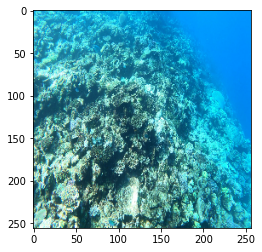

In [25]:
t_img = next(iter(train_ds))
plt.imshow(t_img)

In [32]:
tf.Variable([1,2])[0].assign(2)

<tf.Variable 'UnreadVariable' shape=(2,) dtype=int32, numpy=array([2, 2], dtype=int32)>

In [ ]:
train_df['annotations'].apply(process_annotation)

In [133]:
train_df

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,filepath
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",/content/starfish/train_images/video_0/16.jpg
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",/content/starfish/train_images/video_0/17.jpg
18,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",/content/starfish/train_images/video_0/18.jpg
19,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",/content/starfish/train_images/video_0/19.jpg
20,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",/content/starfish/train_images/video_0/20.jpg
...,...,...,...,...,...,...,...
23369,2,29859,10628,2856,2-10628,"[{'x': 92, 'y': 532, 'width': 40, 'height': 37}]",/content/starfish/train_images/video_2/10628.jpg
23370,2,29859,10629,2857,2-10629,"[{'x': 78, 'y': 569, 'width': 40, 'height': 37}]",/content/starfish/train_images/video_2/10629.jpg
23371,2,29859,10630,2858,2-10630,"[{'x': 65, 'y': 606, 'width': 41, 'height': 37}]",/content/starfish/train_images/video_2/10630.jpg
23372,2,29859,10631,2859,2-10631,"[{'x': 51, 'y': 643, 'width': 44, 'height': 37}]",/content/starfish/train_images/video_2/10631.jpg


In [98]:
#
# Get annotation dataset
#
# Note: image_id = {video_id}-{video_frame}
fpaths = image_filepaths
fpaths = [fpath.split('/content/starfish/train_images/')[1] for fpath in fpaths]
image_id = [fpath.split('/')[0][-1] + '-' + fpath.split('/')[1].split('.')[0] for fpath in fpaths]
abs_annotations_df = train_df[['image_id', 'annotations']].set_index('image_id')
abs_annotations_df = abs_annotations_df.loc[image_id]
abs_annotations_df = abs_annotations_df['annotations'].apply(lambda x: json.loads(x.replace("'", '"')))
from collections import defaultdict
def process(x):
    # Format - (xmin, ymin, width, height)
    if len(x) == 0:
        out = []
    if len(x) == 1:
        out = x[0]
        out = [list(out.values())]
    if len(x) > 1:
        out = []
        for d in x:
            out.append(list(d.values()))
    return out
abs_annotations_df = abs_annotations_df.apply(process)

In [ ]:
abs_annotations_df

In [ ]:
smooth_cnts = [0, 4, 8, 16]
res = abs_annotations_df.apply(lambda x: from_annotations_to_gradient_mask(x, sigma=25.0, num_smooths=smooth_cnts))

# Model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# CNN
# In Image? or Not in Image?
# Push in side boundaries (relative %)
# Input - Image
# Output - In Image Flag? (Confidence)
# Output - % Change of respective boundary
# Loss - L2 Distance from True Boundary

In [ ]:
basemodel = keras.applications.efficientnet.EfficientNetB0(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

In [ ]:
class StarfishModel(keras.Model):
    def __init__(self, basemodel):
        super(StarfishModel, self).__init__()
        self.basemodel = basemodel # :: (None, None, None, 1280)
        self.globalpool2d = layers.GlobalAveragePooling2D() # :: (None, 1280)
        self.is_object_head = keras.Sequential([
            layers.Dense(1, activation='softmax')
        ])
        self.boundary_delta_head = keras.Sequential([
            layers.Dense(1, activation='softmax')
        ])

    def call(self, sample):
        image = sample['image']
        features = self.basemodel(image)
        pooled_features = self.globalpool2d(features)
        is_obj = self.is_object_head(pooled_features)
        bounds_delta = self.boundary_delta_head(pooled_features)
        return is_obj, bounds_delta

    def compile(self, optimizer):
        super(StarfishModel, self).compile()
        self.optimizer = optimizer

    @tf.function
    def train_step(self, sample):
        has_annotation = sample['has_annotation']
        is_obj_tar = tf.cast(sample['has_annotation'], tf.float32)
        bounds_delta_tar = sample['rside_tar_bounds']
        max_bounds_delta_tar = tf.reduce_max(bounds_delta_tar)
        
        with tf.GradientTape() as tape:
            is_obj, bounds_delta = self.call(sample)
            is_obj_loss = tf.losses.binary_crossentropy(is_obj, is_obj_tar)
            loss = is_obj_loss
            if has_annotation:
                bounds_delta_loss = tf.losses.mse(bounds_delta, max_bounds_delta_tar)
                loss += bounds_delta_loss
            else:
                bounds_delta_loss = tf.constant([])

        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"is_obj_loss": is_obj_loss, "bounds_delta_loss": bounds_delta_loss}

In [ ]:
sample = next(iter(train_ds))

In [ ]:
model = StarfishModel(basemodel)
model.compile(keras.optimizers.Adam())

In [ ]:
model(sample)

(<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>)

In [ ]:
model.train_step(sample)

{'bounds_delta_loss': <tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>,
 'is_obj_loss': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([15.424949], dtype=float32)>}

### Train "Is Object" Head First

In [ ]:
model.boundary_delta_head.trainable = False

In [ ]:
is_obj_train_ds = train_ds.map(lambda x: x['image'][0]).batch(32)

In [ ]:
model.boundary_delta_head.trainable = True